# **Feature Engineering**

Feature engineer several variables in order to feed them to two different ML approaches:

- Classification: Predicting the average rating of a wine based on its attributes and the sommelier's review.
- Regression: Based on the classification results and the wine context, predict the price od the wine.

For this we will engineer the numerical and categorical variables we obtained after the web scrapping and cleaning process.

The ultimate goal will be to produce a hypothetical scenario were wine businesses can create several strategies and use this tool as support for market success.

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import zipfile

import nltk
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.help import upenn_tagset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbalancedPipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
# Opening zipfile and reading it to a dataframe
with zipfile.ZipFile('wine_reviews_clean.zip', 'r') as zipf:
    zipf.extractall('')

df = pd.read_csv('wine_reviews_clean.csv')

os.remove('wine_reviews_clean.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421017 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                421017 non-null  object 
 1   Variety             421017 non-null  object 
 2   Country             421017 non-null  object 
 3   Region              386109 non-null  object 
 4   Zone                253609 non-null  object 
 5   Attr_1              417986 non-null  object 
 6   Attr_2              76720 non-null   object 
 7   Winemaker_notes     95234 non-null   object 
 8   Review              93840 non-null   object 
 9   Alcohol_percentage  420952 non-null  float64
 10  Alcohol_vol         420952 non-null  float64
 11  Avg_rating          45970 non-null   float64
 12  N_ratings           45970 non-null   float64
 13  Price_Feature       419607 non-null  float64
 14  Year                418078 non-null  float64
dtypes: float64(6), object(9)
memory us

,Name,Variety,Country,Region,Zone,Attr_1,Attr_2,Winemaker_notes,Review,Alcohol_percentage,Alcohol_vol,Avg_rating,N_ratings,Price_Feature,Year
0,M. Chapoutier La Combe Pilate Esteban Brut Nature,Vintage Sparkling Wine,France,Rhone,NaN,Sparkling & Champagne,Green Wine,NaN,NaN,10.0,750.0,5.0,15.0,49.99,2020.0
1,Vinos de Arganza Alvarez de Toledo Godello,Godello,Spain,NaN,NaN,White Wine,NaN,This wine has a bright yellow color with fresh...,NaN,0.0,750.0,5.0,13.0,10.99,2020.0
2,Louis Latour Vosne-Romanee,Pinot Noir,France,Burgundy,Cote d'Or,Red Wine,Boutique,NaN,"Toasty, spicy aromas introduce this rich, silk...",0.0,750.0,5.0,20.0,119.99,2019.0
3,Chateau Bouscaut,Bordeaux Red Blends,France,Bordeaux,Pessac-Leognan,Red Wine,NaN,"Blend: 61% Merlot, 33% Cabernet Sauvignon, 6% ...",This estate continues to produce brilliant win...,14.5,750.0,5.0,17.0,44.99,2020.0
4,Brandini Barolo La Morra,Nebbiolo,Italy,Piedmont,Barolo,Red Wine,Green Wine,"Made with organically farmed fruit, the La Mor...","Aromas of cherries, strawberries and tar with ...",14.0,750.0,5.0,19.0,63.99,2015.0


## **Categorical**

The first thing to do is to know how to process text. In the case of this particular dataset, there are two text variables. Winemaker_notes and Review. Each one of them has to be cleaned and then transformed into input we can really use for classification. The overall process we will follow is the next:

- Strip out the text of any stop words.
- Lemmatize the text so we have only the true concept of each word present.
- The rest of the categorical values will be processed in a OneHotEncoding manner when performing ML tests.

In [5]:
# Function to delete stopwords from the text
stop_words = set(stopwords.words('english'))
def strip_stopwords_lemmatize(text, lemmatize=True):
    try:
        # Convert text into lowercase
        text = text.lower()

        # Remove non alphanumerical characters and split the text into words
        words = re.findall(r'\b\w+\b', text)

        # Remove stopwords
        clean_words = [word for word in words if word not in stop_words]

        if lemmatize:
            # Lemmatize using WordNetLemmatizer
            WNLemma = WordNetLemmatizer()
            lemmatized_words = [WNLemma.lemmatize(word) for word in clean_words]
            lemmatized_text = ' '.join(lemmatized_words)
            return lemmatized_text
        else:
            # Cleaned text
            cleaned_text = ' '.join(clean_words)
            return cleaned_text
    except:
        # Case when there is no text to analyze
        return np.nan

In [6]:
strip_stopwords_lemmatize(df.iloc[27,7], lemmatize=True)

'pair fresh fruit especially strawberry peach berry fruit fruitcake cooky sweet biscuit'

In [7]:
strip_stopwords_lemmatize(df.iloc[27,7], lemmatize=False)

'pair fresh fruit especially strawberries peaches berry fruits fruitcakes cookies sweet biscuits'

In [8]:
# Applying the lemmatized approach for both the winemakers notes and the reviews
df2 = df.copy()

df2['Winemaker_notes'] = df['Winemaker_notes'].apply(strip_stopwords_lemmatize, lemmatize=True)
df2['Review'] = df['Review'].apply(strip_stopwords_lemmatize, lemmatize=True)

## **Numerical**

For this approach we can apply different methods to engineer the dataset. Some of the approaches we will take are the next ones.

- Eliminate the outliers based on a normal distribution using z-values.
- Transform the Avg_rating value into a ordinal categorical feature based on the performed EDA.
- Use MinMaxScaling to process numeric values when performing ML experiments.

In [9]:
# Inspecting the numerical columns to check whether is need to engineer this features
df3 = df2.copy()
df3.select_dtypes('float64').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421017 entries, 0 to 421016
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Alcohol_percentage  420952 non-null  float64
 1   Alcohol_vol         420952 non-null  float64
 2   Avg_rating          45970 non-null   float64
 3   N_ratings           45970 non-null   float64
 4   Price_Feature       419607 non-null  float64
 5   Year                418078 non-null  float64
dtypes: float64(6)
memory usage: 19.3 MB


In [10]:
# Check for outliers
def get_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
    outliers = np.where(z_scores > threshold, np.nan, 0)
    return outliers

outliers = df3.select_dtypes('float64').apply(get_outliers, axis=0)

outliers_df = df3.join(outliers, rsuffix='_IsOutlier')

outliers_df.iloc[:, -6:].notna().sum()

Alcohol_percentage_IsOutlier    420998
Alcohol_vol_IsOutlier           415141
Avg_rating_IsOutlier            420717
N_ratings_IsOutlier             420362
Price_Feature_IsOutlier         412648
Year_IsOutlier                  418243
dtype: int64

In [11]:
# Eliminate this outliers
clean_df = outliers_df.dropna(subset=outliers_df.columns.tolist()[-6:])
clean_df = clean_df.drop(outliers_df.columns.tolist()[-6:], axis=1)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405906 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                405906 non-null  object 
 1   Variety             405906 non-null  object 
 2   Country             405906 non-null  object 
 3   Region              371395 non-null  object 
 4   Zone                241475 non-null  object 
 5   Attr_1              403100 non-null  object 
 6   Attr_2              68063 non-null   object 
 7   Winemaker_notes     89805 non-null   object 
 8   Review              84430 non-null   object 
 9   Alcohol_percentage  405841 non-null  float64
 10  Alcohol_vol         405841 non-null  float64
 11  Avg_rating          44313 non-null   float64
 12  N_ratings           44313 non-null   float64
 13  Price_Feature       405168 non-null  float64
 14  Year                403193 non-null  float64
dtypes: float64(6), object(9)
memory us

## **Classification**

Our intention is to classify the Avg_rating variable based on the other data available. To achieve this we will perform several experiments:

- Based only on text data, Winemaker_notes and Review.
- Based only on categorical data, all data that is not numerical.
- Based only in numerical data such as Alcohol_vol, Alcohol_percentage, Year, etc...
- Based on a combination of numerical and categorical data, excluiding the text data.
- Based on all the available variables.

**NOTE**: For performance issues we will use a Naive Bayes approach from sklearn, more specifically a ComplementNB approach. This Naive Bayes implementation is great for imbalanced classes.

The next cell indicates the data we can manipulate in order to review each experiments performance. We can add more data later if needed, depending on the experiment.

In [12]:
review = 'This captivating red wine showcases a delightful blend of flavors, making it a memorable choice for wine enthusiasts. Its rich character leaves a lasting impression, perfect for savoring on special occasions.'
bad_review = "This red wine is truly disappointing; it's harsh and unpalatable, with a strange aftertaste that lingers unpleasantly. I regret spending my money on it."
winemaker = 'Crafted with passion and expertise, this red wine embodies the essence of our vineyard, offering a symphony of flavors and a remarkable sensory journey. Explore the intricate details of each sip and experience the artistry behind our winemaking.'


test_data = pd.DataFrame({
    'Variety':'Rhone Red Blends',
    'Country':'France',
    'Region':'Rhone',
    'Attr_1':'Red Wine',
    'Winemaker_notes':strip_stopwords_lemmatize(winemaker, lemmatize=True),
    'Review':strip_stopwords_lemmatize(review, lemmatize=True),
    'Alcohol_percentage':14.5,
    'Alcohol_vol':750,
    'Avg_rating':4.2,
    'N_ratings':10,
    'Price_Feature': 25.99,
    'Year':2018
}, index=['test_data'])

test_data.iloc[0]

Variety                                                Rhone Red Blends
Country                                                          France
Region                                                            Rhone
Attr_1                                                         Red Wine
Winemaker_notes       crafted passion expertise red wine embodies es...
Review                captivating red wine showcase delightful blend...
Alcohol_percentage                                                 14.5
Alcohol_vol                                                         750
Avg_rating                                                          4.2
N_ratings                                                            10
Price_Feature                                                     25.99
Year                                                               2018
Name: test_data, dtype: object

### *Text Data*

Great    37114
Good      7356
Name: Rating_class, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44470 entries, 3 to 421006
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                44470 non-null  object 
 1   Variety             44470 non-null  object 
 2   Country             44470 non-null  object 
 3   Region              41788 non-null  object 
 4   Zone                29362 non-null  object 
 5   Attr_1              44074 non-null  object 
 6   Attr_2              20157 non-null  object 
 7   Winemaker_notes     44470 non-null  object 
 8   Review              44470 non-null  object 
 9   Alcohol_percentage  44437 non-null  float64
 10  Alcohol_vol         44437 non-null  float64
 11  Avg_rating          18710 non-null  float64
 12  N_ratings           18710 non-null  float64
 13  Price_Feature       44332 non-null  float64
 14  Year                44053 non-null  fl

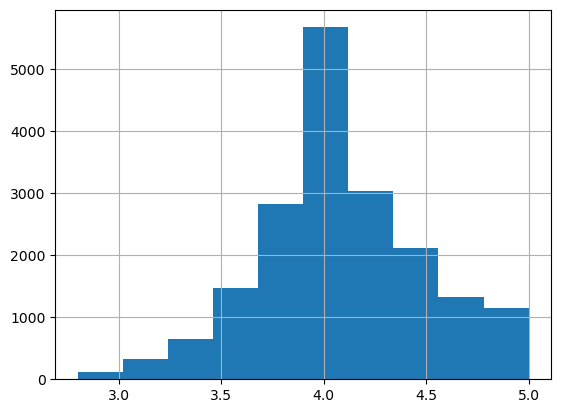

In [13]:
# Trying a single approach for 
df4 = clean_df.copy()
df4 = df4.dropna(subset=['Winemaker_notes', 'Review'])
df4 = df4.drop(df4[df4['Avg_rating'] < 2.5].index)
df4['Rating_class'] = np.where(df4['Avg_rating'] < 4.0, 'Good', 'Great')

print(df4['Rating_class'].value_counts())

df4.info()

df4['Avg_rating'].hist(bins=10);

It is important to note that we decided to break down the problem of predicting the rating to a classification problem. This way we can ensure that we are able to use fast algorithms like Naive Bayes. Also, in order to create the classes we took a look into the distribution of the Avg_rating feature and decided for it to be a binary class.

In [14]:
# Need to create over sampling to balance classes
from imblearn.over_sampling import RandomOverSampler

# Training a small classifier to check whether reviews can predict the rating class
exp1 = df4[['Winemaker_notes', 'Review', 'Rating_class']].dropna()

# Divide classifiers and target
X = exp1.iloc[:, :-1]
y = exp1.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),     
        ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),                          
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline for preprocessing text and classification
exp1_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Train
exp1_clf.fit(X_train, y_train)

# Make predictions
y_pred = exp1_clf.predict(X_test)

# Model evaluation
print(classification_report(y_test, y_pred))

[ColumnTransformer]  (1 of 2) Processing Winemaker_notes, total=   3.9s
[ColumnTransformer] ........ (2 of 2) Processing Review, total=   4.6s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   8.6s
[Pipeline] ........... (step 2 of 3) Processing sampler, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
              precision    recall  f1-score   support

        Good       0.28      0.59      0.38      1471
       Great       0.90      0.70      0.79      7423

    accuracy                           0.68      8894
   macro avg       0.59      0.65      0.58      8894
weighted avg       0.79      0.68      0.72      8894



In [15]:
# Testing with the fake review generated by chatgpt
exp1_clf.predict(test_data[['Winemaker_notes', 'Review']])

array(['Great'], dtype='<U5')

Accuracy is around 70%, making the classifier niether great nor bad. This allows us to estimate that some of the reviews and winemaker_notes are actually statistically realted to the average rating of the wine in this particular website.

From this point we can make a preliminary conclusion that the text data has an average impact on the rating of a wine. This means that, taking into account the opinion of both producers and tasters is important for consumers when rating a wine.

In [16]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Winemaker_notes', 'Review'])

pdf['Rating_class'] = exp1_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                          \
              count unique                top freq mean  std  min  25%  50%   
Rating_class                                                                  
Good          12978   7486  Trimbach Riesling   12  NaN  NaN  NaN  NaN  NaN   
Great         31492  15338  Ridge Monte Bello   16  NaN  NaN  NaN  NaN  NaN   

                       Variety                                               \
              75%  max   count unique         top  freq mean  std  min  25%   
Rating_class                                                                  
Good          NaN  NaN   12978    124  Chardonnay  1252  NaN  NaN  NaN  NaN   
Great         NaN  NaN   31492    130  Pinot Noir  4286  NaN  NaN  NaN  NaN   

                            Country                                         \
              50%  75%  max   count unique            top   freq mean  std   
Rating_class                                                                 
Good          NaN  NaN  NaN   12978     27  United States   4662  NaN  NaN   
Great         NaN  NaN  NaN   31492     26  United States  11245  NaN  NaN   

                                      Region                                \
              min  25%  50%  75%  max  count unique         top  freq mean   
Rating_class                                                                 
Good          NaN  NaN  NaN  NaN  NaN  12125    131  California  3705  NaN   
Great         NaN  NaN  NaN  NaN  NaN  29663    135  California  9040  NaN   

                                             Zone                              \
              std  min  25%  50%  75%  max  count unique            top  freq   
Rating_class                                                                    
Good          NaN  NaN  NaN  NaN  NaN  NaN   7179    113  Central Coast  1182   
Great         NaN  NaN  NaN  NaN  NaN  NaN  22183    132    Napa Valley  3554   

                                                Attr_1                   \
             mean  std  min  25%  50%  75%  max  count unique       top   
Rating_class                                                              
Good          NaN  NaN  NaN  NaN  NaN  NaN  NaN  12936      8  Red Wine   
Great         NaN  NaN  NaN  NaN  NaN  NaN  NaN  31138      8  Red Wine   

                                                       Attr_2         \
               freq mean  std  min  25%  50%  75%  max  count unique   
Rating_class                                                           
Good           7199  NaN  NaN  NaN  NaN  NaN  NaN  NaN   5472      6   
Great         22293  NaN  NaN  NaN  NaN  NaN  NaN  NaN  14685      6   

                                                                   \
                     top  freq mean  std  min  25%  50%  75%  max   
Rating_class                                                        
Good          Green Wine  2405  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great           Boutique  4829  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             Winemaker_notes                                                   \
                       count unique                        top freq mean  std   
Rating_class                                                                    
Good                   12978  11676  vegan vegetarian friendly   21  NaN  NaN   
Great                  31492  27492                              67  NaN  NaN   

                                      Review         \
              min  25%  50%  75%  max  count unique   
Rating_class                                          
Good          NaN  NaN  NaN  NaN  NaN  12978  12805   
Great         NaN  NaN  NaN  NaN  NaN  31492  30853   

                                                                           \
                                                            top freq mean   
Rating_class                                                                
Good          combination licorice fenn

By predicting all the dataset with available winemaker_notes and review we can groupby this classification made by our first experiment and explore the characteristics of each one.

When it comes to categorical values most of them correspond to data in the US, California, and certain zones, as well as for Red Wine types and varieties.

Now for numerical values:
- Alcohol_percentage is lower in Great wines.
- Alcohol_vol is pretty much the same.
- Avg_rating is obviously greater in the Great wines.
- Price-Feature is significantly greater in Great wines.
- Great wines have a longer vintage than good wines.

Now, in accordance to this criteria, we can assure that many of the assumptions made by the model correspond to a logical perspective of wines in the current manrket. Finer, more expensive, more and better rated wines can be considered greater than most others, and this seems to be capture by a probabilistic model like ComplementNB.

### *Text and Categorical Data*

In [17]:
# Try the same experiment but with more features
df5 = clean_df.copy()
df5 = df5.dropna(subset=['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review'])
df5 = df5.drop(df5[df5['Avg_rating'] < 2.5].index)
df5['Rating_class'] = np.where(df5['Avg_rating'] < 4.0, 'Good', 'Great')

# New dataset for classification
exp2 = df5[['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review', 'Rating_class']]

# Divide classifiers and target
X = exp2.iloc[:, :-1]
y = exp2.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),     
        ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),                          
        ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),                     
        ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
        ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
        ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1'])
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline with the preprocessor, SMOTE for oversampling, and MultinomialNB
exp2_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Fit the pipeline on the training data
exp2_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = exp2_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

[ColumnTransformer]  (1 of 6) Processing Winemaker_notes, total=   3.7s
[ColumnTransformer] ........ (2 of 6) Processing Review, total=   4.3s
[ColumnTransformer] ....... (3 of 6) Processing Variety, total=   0.0s
[ColumnTransformer] ....... (4 of 6) Processing Country, total=   0.0s
[ColumnTransformer] ........ (5 of 6) Processing Region, total=   0.0s
[ColumnTransformer] ........ (6 of 6) Processing Attr_1, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   8.1s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.5s
Classification Report:
              precision    recall  f1-score   support

        Good       0.30      0.66      0.41      1374
       Great       0.91      0.69      0.79      6931

    accuracy                           0.69      8305
   macro avg       0.60      0.68      0.60      8305
weighted avg       0.81      0.69      0.72      8305



In [18]:
# Testing with the fake review generated by chatgpt
exp2_clf.predict(test_data[['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review']])

array(['Great'], dtype='<U5')

Comparing both approaches is easy to see how the overall accuracy doesn't change at all, this might be the reason why both classifiers predicted the same class. The metrics that do change are the ones in respect of precision and recall.

- **Precision** increases slightly for both classes.
- **Recall** increases for both cases, but more so for the Good Class making it better at reducing the number of False Negatives.
- **F1-Score** increases slightly for the Good Class and stays the same for the Great Class, this indicates an overall performance boost.

In [19]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review'])

pdf['Rating_class'] = exp2_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                         \
              count unique                                        top freq   
Rating_class                                                                 
Good          13656   7451                          Trimbach Riesling   12   
Great         27867  13353  Chateau de Beaucastel Chateauneuf-du-Pape   16   

                                                Variety         \
             mean  std  min  25%  50%  75%  max   count unique   
Rating_class                                                     
Good          NaN  NaN  NaN  NaN  NaN  NaN  NaN   13656    113   
Great         NaN  NaN  NaN  NaN  NaN  NaN  NaN   27867    117   

                                                                        \
                          top  freq mean  std  min  25%  50%  75%  max   
Rating_class                                                             
Good          Sauvignon Blanc  1290  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great              Pinot Noir  4404  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             Country                                                        \
               count unique            top   freq mean  std  min  25%  50%   
Rating_class                                                                 
Good           13656     14  United States   4997  NaN  NaN  NaN  NaN  NaN   
Great          27867     14  United States  10857  NaN  NaN  NaN  NaN  NaN   

                       Region                                               \
              75%  max  count unique         top  freq mean  std  min  25%   
Rating_class                                                                 
Good          NaN  NaN  13656    128  California  4010  NaN  NaN  NaN  NaN   
Great         NaN  NaN  27867    123  California  8701  NaN  NaN  NaN  NaN   

                              Zone                                             \
              50%  75%  max  count unique            top  freq mean  std  min   
Rating_class                                                                    
Good          NaN  NaN  NaN   7590    114  Central Coast  1212  NaN  NaN  NaN   
Great         NaN  NaN  NaN  21686    123    Napa Valley  3458  NaN  NaN  NaN   

                                 Attr_1                                    \
              25%  50%  75%  max  count unique       top   freq mean  std   
Rating_class                                                                
Good          NaN  NaN  NaN  NaN  13656      6  Red Wine   7394  NaN  NaN   
Great         NaN  NaN  NaN  NaN  27867      8  Red Wine  20435  NaN  NaN   

                                      Attr_2                                 \
              min  25%  50%  75%  max  count unique          top  freq mean   
Rating_class                                                                  
Good          NaN  NaN  NaN  NaN  NaN   5948      6   Green Wine  2572  NaN   
Great         NaN  NaN  NaN  NaN  NaN  13302      6  Collectible  4698  NaN   

                                           Winemaker_notes         \
              std  min  25%  50%  75%  max           count unique   
Rating_class                                                        
Good          NaN  NaN  NaN  NaN  NaN  NaN           13656  12306   
Great         NaN  NaN  NaN  NaN  NaN  NaN           27867  24227   

                                                                            \
                                    top freq mean  std  min  25%  50%  75%   
Rating_class                                                                 
Good          vegan vegetarian friendly   26  NaN  NaN  NaN  NaN  NaN  NaN   
Great              blend 100 chardonnay   59  NaN  NaN  NaN  NaN  NaN  NaN   

                  Review         \
              max  count unique   
Rating_class                      
Good          NaN  13656  13479   
Great         NaN  27867  27266   

                                       

Now with this approach we can identify the characteristics of each class. The same thing happens with the previous classifier we trained, most categorical values correspond to US wines, this seems plausible because most wines in the dataset that have a review are the american wines.

For the rest of the numerical features it can be seen that the behavior is pretty much the same, with the exception that the boundaries between classes are more explicit, making this experiment more tailored for the classification problem.

### *Numerical Data*

In [37]:
# Experiment 3
df6 = clean_df.copy()
df6 = df6.iloc[:, 9:]
df6 = df6.drop(df6[df6['Avg_rating'] < 2.5].index)
df6['Rating_class'] = np.where(df6['Avg_rating'] < 4.0, 'Good', 'Great')

# Dataset for experimentation
exp3 = df6.drop(['Avg_rating', 'N_ratings'], axis=1).dropna(subset=['Alcohol_percentage', 'Alcohol_vol', 
                                                                    'Price_Feature', 'Year'])

# Separating classifiers and target
X = exp3.iloc[:, :-1]
y = exp3.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
        ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
        ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
        ('Year', MinMaxScaler(), ['Year'])
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline with the preprocessor
exp3_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Fit the pipeline on the training data
exp3_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = exp3_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

[ColumnTransformer]  (1 of 4) Processing Alcohol_percentage, total=   0.0s
[ColumnTransformer] ... (2 of 4) Processing Alcohol_vol, total=   0.0s
[ColumnTransformer] . (3 of 4) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (4 of 4) Processing Year, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   2.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   5.0s
Classification Report:
              precision    recall  f1-score   support

        Good       0.09      0.69      0.16      3631
       Great       0.98      0.68      0.80     76862

    accuracy                           0.68     80493
   macro avg       0.54      0.69      0.48     80493
weighted avg       0.94      0.68      0.77     80493



In [38]:
# Testing with the fake review generated by chatgpt
exp3_clf.predict(test_data[['Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year']])

array(['Good'], dtype='<U5')

In [39]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

pdf['Rating_class'] = exp3_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                       \
               count unique                            top freq mean  std   
Rating_class                                                                
Good          134269  61185           Ferrari-Carano Siena   19  NaN  NaN   
Great         268192  93224  Robert Foley Vineyards Claret   32  NaN  NaN   

                                      Variety                                 \
              min  25%  50%  75%  max   count unique         top   freq mean   
Rating_class                                                                   
Good          NaN  NaN  NaN  NaN  NaN  134269    144  Pinot Noir  16068  NaN   
Great         NaN  NaN  NaN  NaN  NaN  268192    144  Pinot Noir  34447  NaN   

                                           Country                        \
              std  min  25%  50%  75%  max   count unique            top   
Rating_class                                                               
Good          NaN  NaN  NaN  NaN  NaN  NaN  134269     36  United States   
Great         NaN  NaN  NaN  NaN  NaN  NaN  268192     38  United States   

                                                        Region         \
               freq mean  std  min  25%  50%  75%  max   count unique   
Rating_class                                                            
Good          60207  NaN  NaN  NaN  NaN  NaN  NaN  NaN  123176    159   
Great         94906  NaN  NaN  NaN  NaN  NaN  NaN  NaN  245326    159   

                                                                      Zone  \
                     top   freq mean  std  min  25%  50%  75%  max   count   
Rating_class                                                                 
Good          California  47433  NaN  NaN  NaN  NaN  NaN  NaN  NaN   80452   
Great         California  73889  NaN  NaN  NaN  NaN  NaN  NaN  NaN  160093   

                                                                              \
             unique            top   freq mean  std  min  25%  50%  75%  max   
Rating_class                                                                   
Good            142  Central Coast  12480  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great           142    Napa Valley  20322  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

              Attr_1                                                         \
               count unique       top    freq mean  std  min  25%  50%  75%   
Rating_class                                                                  
Good          133605      8  Red Wine   87015  NaN  NaN  NaN  NaN  NaN  NaN   
Great         266587      9  Red Wine  177594  NaN  NaN  NaN  NaN  NaN  NaN   

                  Attr_2                                                      \
              max  count unique          top   freq mean  std  min  25%  50%   
Rating_class                                                                   
Good          NaN  32378      6    Screw Cap  10631  NaN  NaN  NaN  NaN  NaN   
Great         NaN  35084      6  Collectible  13536  NaN  NaN  NaN  NaN  NaN   

                       Winemaker_notes                                         \
              75%  max           count unique                   top freq mean   
Rating_class                                                                    
Good          NaN  NaN           49343  43633  blend 100 chardonnay  107  NaN   
Great         NaN  NaN           39363  32598                         93  NaN   

                                           Review                             \
              std  min  25%  50%  75%  max  count unique            top freq   
Rating_class                                                                   
Good          NaN  NaN  NaN  NaN  NaN  NaN  45627  44801  editor choice   11   
Great         NaN  NaN  NaN  NaN  NaN  NaN  37761  37013  editor choice    4   

                                                Alcohol_percentage             \
     

This classifier did pretty well for Great wines, but not so good for Good wines

As it can be seen, when presented with the test data, this classifier did differently than the other two trained, these other two predicted Great for the wine, while this new one predicted Good.

Performing the same grouping operation to visualize the attributes of each class, we can see how there are many similarities between all classifiers, mainly concerning the categorical values.
- Napa Valley seems like the best place for Great wines.
- Collectible is the main attribute for Great wines.
- Lower alcohol wines tend to be better, as well as more expensive wines.
- Longer vintage wines are better too.

One thing to note is that the classifier wasn't able to make difference of the wines based on the rating, this is because we are trying to about data leakage into the model by providing some information about the Rating and the Number of Ratings.

In [40]:
clean_df.columns

Index(['Name', 'Variety', 'Country', 'Region', 'Zone', 'Attr_1', 'Attr_2',
       'Winemaker_notes', 'Review', 'Alcohol_percentage', 'Alcohol_vol',
       'Avg_rating', 'N_ratings', 'Price_Feature', 'Year'],
      dtype='object')

### *Numerical and Text data*

In [42]:
# Experiment 4
df7 = clean_df.copy()
df7 = df7.iloc[:, 7:]
df7 = df7.drop(df7[df7['Avg_rating'] < 2.5].index)
df7['Rating_class'] = np.where(df7['Avg_rating'] < 4.0, 'Good', 'Great')

# Dataset for experimentation
exp4 = df7.drop(['Avg_rating', 'N_ratings'], axis=1).dropna(subset=['Winemaker_notes', 'Review', 'Alcohol_percentage',
                                                                    'Alcohol_vol', 'Price_Feature', 'Year'])

# Separating classifiers and target
X = exp4.iloc[:, :-1]
y = exp4.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
        ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
        ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
        ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
        ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
        ('Year', MinMaxScaler(), ['Year'])
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline with the preprocessor
exp4_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Fit the pipeline on the training data
exp4_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = exp4_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

[ColumnTransformer]  (1 of 6) Processing Winemaker_notes, total=   3.7s
[ColumnTransformer] ........ (2 of 6) Processing Review, total=   4.0s
[ColumnTransformer]  (3 of 6) Processing Alcohol_percentage, total=   0.0s
[ColumnTransformer] ... (4 of 6) Processing Alcohol_vol, total=   0.0s
[ColumnTransformer] . (5 of 6) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (6 of 6) Processing Year, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   8.1s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
Classification Report:
              precision    recall  f1-score   support

        Good       0.29      0.61      0.39      1456
       Great       0.90      0.71      0.79      7327

    accuracy                           0.69      8783
   macro avg       0.60      0.66      0.59      8783
weighted avg       0.80      0.69      0.73      8783



In [43]:
# Testing with the fake review generated by chatgpt
exp4_clf.predict(test_data[['Winemaker_notes', 'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year']])

array(['Great'], dtype='<U5')

In [44]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Winemaker_notes', 'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

pdf['Rating_class'] = exp4_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                          \
              count unique                top freq mean  std  min  25%  50%   
Rating_class                                                                  
Good          13093   7404  Trimbach Riesling   12  NaN  NaN  NaN  NaN  NaN   
Great         30822  14818  Ridge Monte Bello   16  NaN  NaN  NaN  NaN  NaN   

                       Variety                                               \
              75%  max   count unique         top  freq mean  std  min  25%   
Rating_class                                                                  
Good          NaN  NaN   13093    122  Chardonnay  1330  NaN  NaN  NaN  NaN   
Great         NaN  NaN   30822    125  Pinot Noir  4274  NaN  NaN  NaN  NaN   

                            Country                                         \
              50%  75%  max   count unique            top   freq mean  std   
Rating_class                                                                 
Good          NaN  NaN  NaN   13093     26  United States   4758  NaN  NaN   
Great         NaN  NaN  NaN   30822     26  United States  11062  NaN  NaN   

                                      Region                                \
              min  25%  50%  75%  max  count unique         top  freq mean   
Rating_class                                                                 
Good          NaN  NaN  NaN  NaN  NaN  12226    133  California  3774  NaN   
Great         NaN  NaN  NaN  NaN  NaN  29064    132  California  8895  NaN   

                                             Zone                              \
              std  min  25%  50%  75%  max  count unique            top  freq   
Rating_class                                                                    
Good          NaN  NaN  NaN  NaN  NaN  NaN   7347    114  Central Coast  1187   
Great         NaN  NaN  NaN  NaN  NaN  NaN  21853    128    Napa Valley  3525   

                                                Attr_1                   \
             mean  std  min  25%  50%  75%  max  count unique       top   
Rating_class                                                              
Good          NaN  NaN  NaN  NaN  NaN  NaN  NaN  13067      8  Red Wine   
Great         NaN  NaN  NaN  NaN  NaN  NaN  NaN  30569      8  Red Wine   

                                                       Attr_2         \
               freq mean  std  min  25%  50%  75%  max  count unique   
Rating_class                                                           
Good           7123  NaN  NaN  NaN  NaN  NaN  NaN  NaN   5600      6   
Great         22238  NaN  NaN  NaN  NaN  NaN  NaN  NaN  14366      6   

                                                                   \
                     top  freq mean  std  min  25%  50%  75%  max   
Rating_class                                                        
Good          Green Wine  2413  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great           Boutique  4813  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             Winemaker_notes                                                   \
                       count unique                        top freq mean  std   
Rating_class                                                                    
Good                   13093  11732  vegan vegetarian friendly   21  NaN  NaN   
Great                  30822  26907                              64  NaN  NaN   

                                      Review         \
              min  25%  50%  75%  max  count unique   
Rating_class                                          
Good          NaN  NaN  NaN  NaN  NaN  13093  12895   
Great         NaN  NaN  NaN  NaN  NaN  30822  30225   

                                                                           \
                                                            top freq mean   
Rating_class                                                                
Good          2017 claret blend 44 cabe

With this approach we get a close result to the Categorical and Text Data experiement, where it excells at predicting Great wines and has a harder time to predict Good wines, but it does it better than most other experiments.

For the test data it predicts it to be Great, having the same result in prediction than most of the other classifiers, excepting the one based solely in numerical data.

Most of the conclusions stay the same:
- Most wines are classified as Great.
- United States and California are dominant in both classes.
- Napa Valley is still the best zone to produce Great wines.
- Boutique attribute is the most related to Great wines.
- Lower alcohol percentage leads to Great wines.
- Number of ratings seem to be unimportant for the classification.
- More expensive wines are categorized as Great wines.
- Longer vintage wines tend to be better.

When it comes to the Avg_rating value when grouping by class is possible to see how there is a much better distinction between Good class wines, that have lesser ratings, and Great class wines that have greater rating scores.

### *Numerical and Categorical Data*

In [49]:
# Experiment 5
df8 = clean_df.copy()
df8 = df8[['Variety', 'Country', 'Region', 'Attr_1', 'Alcohol_percentage', 'Alcohol_vol',
       'Avg_rating', 'N_ratings', 'Price_Feature', 'Year']]
df8 = df8.drop(df8[df8['Avg_rating'] < 2.5].index)
df8['Rating_class'] = np.where(df8['Avg_rating'] < 4.0, 'Good', 'Great')

# Dataset for experimentation
exp5 = df8.drop(['Avg_rating', 'N_ratings'], axis=1).dropna(subset=['Variety', 'Country', 'Region', 'Attr_1', 
                                                                    'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

# Separating classifiers and target
X = exp5.iloc[:, :-1]
y = exp5.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
        ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
        ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
        ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
        ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
        ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
        ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
        ('Year', MinMaxScaler(), ['Year'])
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline with the preprocessor
exp5_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Fit the pipeline on the training data
exp5_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = exp5_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

[ColumnTransformer] ....... (1 of 8) Processing Variety, total=   0.1s
[ColumnTransformer] ....... (2 of 8) Processing Country, total=   0.1s
[ColumnTransformer] ........ (3 of 8) Processing Region, total=   0.1s
[ColumnTransformer] ........ (4 of 8) Processing Attr_1, total=   0.1s
[ColumnTransformer]  (5 of 8) Processing Alcohol_percentage, total=   0.0s
[ColumnTransformer] ... (6 of 8) Processing Alcohol_vol, total=   0.0s
[ColumnTransformer] . (7 of 8) Processing Price_Feature, total=   0.0s
[ColumnTransformer] .......... (8 of 8) Processing Year, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.6s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   2.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   3.7s
Classification Report:
              precision    recall  f1-score   support

        Good       0.08      0.65      0.14      3303
       Great       0.97      0.65      0.78     70036

    accuracy                

In [50]:
# Testing with the fake review generated by chatgpt
exp5_clf.predict(test_data[['Variety', 'Country', 'Region', 'Attr_1',
                            'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year']])

array(['Great'], dtype='<U5')

In [51]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Variety', 'Country', 'Region', 'Attr_1',
                              'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

pdf['Rating_class'] = exp5_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                       \
               count unique                       top freq mean  std  min   
Rating_class                                                                
Good          134740  42625       Tenuta Luce Lucente   33  NaN  NaN  NaN   
Great         231954  71713  Beni di Batasiolo Barolo   31  NaN  NaN  NaN   

                                 Variety                                    \
              25%  50%  75%  max   count unique                 top   freq   
Rating_class                                                                 
Good          NaN  NaN  NaN  NaN  134740    116  Cabernet Sauvignon  20116   
Great         NaN  NaN  NaN  NaN  231954    111          Pinot Noir  46651   

                                                Country                        \
             mean  std  min  25%  50%  75%  max   count unique            top   
Rating_class                                                                    
Good          NaN  NaN  NaN  NaN  NaN  NaN  NaN  134740     13  United States   
Great         NaN  NaN  NaN  NaN  NaN  NaN  NaN  231954     14  United States   

                                                        Region         \
               freq mean  std  min  25%  50%  75%  max   count unique   
Rating_class                                                            
Good          65867  NaN  NaN  NaN  NaN  NaN  NaN  NaN  134740    118   
Great         88379  NaN  NaN  NaN  NaN  NaN  NaN  NaN  231954    138   

                                                                      Zone  \
                     top   freq mean  std  min  25%  50%  75%  max   count   
Rating_class                                                                 
Good          California  55969  NaN  NaN  NaN  NaN  NaN  NaN  NaN   82839   
Great         California  64905  NaN  NaN  NaN  NaN  NaN  NaN  NaN  156851   

                                                                            \
             unique          top   freq mean  std  min  25%  50%  75%  max   
Rating_class                                                                 
Good             98  Napa Valley  13251  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great           133    Cote d'Or  20873  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

              Attr_1                                                         \
               count unique       top    freq mean  std  min  25%  50%  75%   
Rating_class                                                                  
Good          134740      6  Red Wine   80752  NaN  NaN  NaN  NaN  NaN  NaN   
Great         231954      9  Red Wine  163284  NaN  NaN  NaN  NaN  NaN  NaN   

                  Attr_2                                                      \
              max  count unique          top   freq mean  std  min  25%  50%   
Rating_class                                                                   
Good          NaN  29764      6    Screw Cap  10693  NaN  NaN  NaN  NaN  NaN   
Great         NaN  32833      6  Collectible  12422  NaN  NaN  NaN  NaN  NaN   

                       Winemaker_notes                                         \
              75%  max           count unique                   top freq mean   
Rating_class                                                                    
Good          NaN  NaN           41151  35168  blend 100 chardonnay   82  NaN   
Great         NaN  NaN           39263  31963  blend 100 pinot noir  104  NaN   

                                           Review                             \
              std  min  25%  50%  75%  max  count unique            top freq   
Rating_class                                                                   
Good          NaN  NaN  NaN  NaN  NaN  NaN  35323  34535  editor choice    8   
Great         NaN  NaN  NaN  NaN  NaN  NaN  42526  41488  editor choice    6   

                                                Alcohol_percentage             \


This classifier has less accuracy than most other classifiers train, never the less it has one of the highest precision metric for Great wines. But, it performs poorly for Good wines.

The rest of the assumptions in the other conclusions stay the same, excepting that:
- Napa Valley now is considered a Good wine zone, not a Great wine.
- Collectible as the best attribute for Great wines.
- Avg_rating is non important for the wine class (strange)

### *Text, Numerical, and Categorical Data*

In [56]:
# Experiment 6
df9 = clean_df.copy()
df9 = df9[['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes', 'Review', 'Alcohol_percentage', 'Alcohol_vol',
       'Avg_rating', 'Price_Feature', 'Year']]
df9 = df9.drop(df9[df9['Avg_rating'] < 2.5].index)
df9['Rating_class'] = np.where(df9['Avg_rating'] < 4.0, 'Good', 'Great')

# Dataset for experimentation
exp6 = df9.drop(['Avg_rating'], axis=1).dropna(subset=['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes',
                                                        'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

# Separating classifiers and target
X = exp6.iloc[:, :-1]
y = exp6.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('Variety', OneHotEncoder(handle_unknown='ignore'), ['Variety']),
        ('Country', OneHotEncoder(handle_unknown='ignore'), ['Country']),
        ('Region', OneHotEncoder(handle_unknown='ignore'), ['Region']),
        ('Attr_1', OneHotEncoder(handle_unknown='ignore'), ['Attr_1']),
        ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
        ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
        ('Alcohol_percentage', MinMaxScaler(), ['Alcohol_percentage']),
        ('Alcohol_vol', MinMaxScaler(), ['Alcohol_vol']),
        ('Price_Feature', MinMaxScaler(), ['Price_Feature']),
        ('Year', MinMaxScaler(), ['Year'])
    ],
    remainder='passthrough',  # Pass through other columns as is
    verbose=True
)

# Create a pipeline with the preprocessor
exp6_clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(sampling_strategy='not majority', random_state=0)),
    ('clf', ComplementNB())
], verbose=True)

# Fit the pipeline on the training data
exp6_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = exp6_clf.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

[ColumnTransformer] ...... (1 of 10) Processing Variety, total=   0.0s
[ColumnTransformer] ...... (2 of 10) Processing Country, total=   0.0s
[ColumnTransformer] ....... (3 of 10) Processing Region, total=   0.0s
[ColumnTransformer] ....... (4 of 10) Processing Attr_1, total=   0.0s
[ColumnTransformer]  (5 of 10) Processing Winemaker_notes, total=   9.3s
[ColumnTransformer] ....... (6 of 10) Processing Review, total=   9.4s
[ColumnTransformer]  (7 of 10) Processing Alcohol_percentage, total=   0.0s
[ColumnTransformer] .. (8 of 10) Processing Alcohol_vol, total=   0.0s
[ColumnTransformer]  (9 of 10) Processing Price_Feature, total=   0.0s
[ColumnTransformer] ........ (10 of 10) Processing Year, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=  19.0s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.4s
Classification Report:
              precision    recall  f1-score   s

In [57]:
# Testing with the fake review generated by chatgpt
exp6_clf.predict(test_data[['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes',
                            'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year']])

array(['Great'], dtype='<U5')

In [58]:
# Trying to predict the Rating_class with this classifier for all the dataset and see the distribution
pdf = clean_df.dropna(subset=['Variety', 'Country', 'Region', 'Attr_1', 'Winemaker_notes',
                              'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Price_Feature', 'Year'])

pdf['Rating_class'] = exp5_clf.predict(pdf)

pdf.groupby('Rating_class').describe(include='all')

Name                                                         \
              count unique                                        top freq   
Rating_class                                                                 
Good          20838   9453                  Torbreck The Steading Red   15   
Great         20284   9634  Chateau de Beaucastel Chateauneuf-du-Pape   16   

                                                Variety         \
             mean  std  min  25%  50%  75%  max   count unique   
Rating_class                                                     
Good          NaN  NaN  NaN  NaN  NaN  NaN  NaN   20838     98   
Great         NaN  NaN  NaN  NaN  NaN  NaN  NaN   20284     89   

                                                                           \
                             top  freq mean  std  min  25%  50%  75%  max   
Rating_class                                                                
Good          Cabernet Sauvignon  3393  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great                 Pinot Noir  4800  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             Country                                                       \
               count unique            top  freq mean  std  min  25%  50%   
Rating_class                                                                
Good           20838     13  United States  9634  NaN  NaN  NaN  NaN  NaN   
Great          20284     14         France  8457  NaN  NaN  NaN  NaN  NaN   

                       Region                                               \
              75%  max  count unique         top  freq mean  std  min  25%   
Rating_class                                                                 
Good          NaN  NaN  20838    105  California  8245  NaN  NaN  NaN  NaN   
Great         NaN  NaN  20284     97  California  4404  NaN  NaN  NaN  NaN   

                              Zone                                           \
              50%  75%  max  count unique          top  freq mean  std  min   
Rating_class                                                                  
Good          NaN  NaN  NaN  13310     81  Napa Valley  2782  NaN  NaN  NaN   
Great         NaN  NaN  NaN  15834    107    Cote d'Or  2367  NaN  NaN  NaN   

                                 Attr_1                                    \
              25%  50%  75%  max  count unique       top   freq mean  std   
Rating_class                                                                
Good          NaN  NaN  NaN  NaN  20838      6  Red Wine  12928  NaN  NaN   
Great         NaN  NaN  NaN  NaN  20284      6  Red Wine  14776  NaN  NaN   

                                      Attr_2                                 \
              min  25%  50%  75%  max  count unique          top  freq mean   
Rating_class                                                                  
Good          NaN  NaN  NaN  NaN  NaN   9482      6   Green Wine  3287  NaN   
Great         NaN  NaN  NaN  NaN  NaN   9583      6  Collectible  3546  NaN   

                                           Winemaker_notes         \
              std  min  25%  50%  75%  max           count unique   
Rating_class                                                        
Good          NaN  NaN  NaN  NaN  NaN  NaN           20838  18689   
Great         NaN  NaN  NaN  NaN  NaN  NaN           20284  17431   

                                                                            \
                               top freq mean  std  min  25%  50%  75%  max   
Rating_class                                                                 
Good          blend 100 chardonnay   40  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Great                                44  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             Review                                                            \
              count unique                                                top   
Rating_class                                         

## Regression